이번 장에서는 신경망 학습의 핵심 개념들을 만난다. 이번 장에서 다룰 주제는 가중치 매개변수의 최적값을 탐색하는 최적화 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등 모두가 신경망 학습에서 중요한 주제이다. 오버피팅의 대응책인 가중치 감소와 드롭아웃 등의 정규화 방법도 간략히 설명하고 구현해본다. 

# 6.1 매개변수 갱신
신경망 학습의 목적은 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것이다. 이는 곧 매개변수의 최적값을 찾는 문제이며, 이러한 문제를 푸는 것을 **최적화(Optimization)**라 한다. <br><br>
우리는 지금까지 최적의 매개변수 값을 찾는 단서로 매개변수의 기울기(미분)를 이용했다. 매개변수의 기울기를 구해, 기울어진 방향으로 매개변수 값을 갱신하는 일을 몇 번이고 반복해서 점점 최적의 값에 다가갔다. 이것이 **확률적 경사 하강법(SGD)**이란 단순한 방법인데, 매개변수 공간을 무작정 찾는 것보다 '똑똑한' 방법이다. 지금부터 SGD의 단점을 알아본 후 SGD와는 다른 최적화 기법을 소개한다.

## 6.1.1 모험가 이야기
모험가는 주위 경치는 볼 수 없지만 서있는 땅의 기울기는 알 수 있다. 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가자는 것이 SGD의 전략이다.

## 6.1.2 확률적 경사 하강법(SGD)
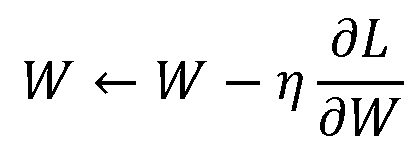

In [1]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]  # 각각 가중치 매개변수와 기울기를 저장

## 6.1.3 SGD의 단점
SGD는 단순하고 구현도 쉽지만, 문제에 따라서는 비효율적일 때가 있다. SGD의 단점을 알아보고자 다음 함수의 최솟값을 구하는 문제를 생각해본다.<br><br>
$$ f(x,y) = \frac{1}{20}x^2 + y^2 $$  


탐색을 시작하는 장소(초깃값)는 (x, y) = (-7.0, 2.0)으로 하여 SGD를 적용해본다. 결과는 다음과 같다.<br><br>
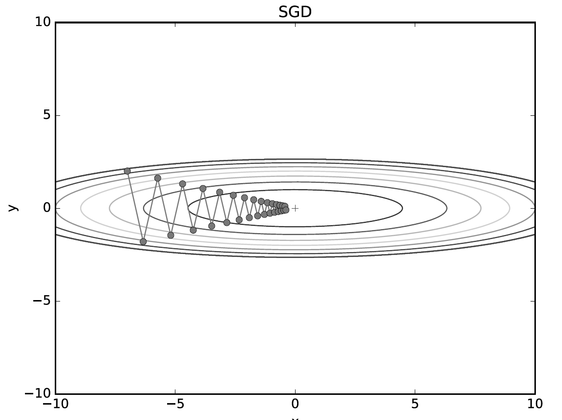

SGD는 위의 그림과 같이 심하게 굽이진 움직임을 보여준다. 상당히 비효율적인 움직임이다. 즉, SGD의 단점은 **비등방성 함수**(방향에 따라 성질, 즉 여기에서는 기울기가 달라지는 함수)에서는 탐색 경로가 비효율적이라는 것이다. 또한, SGD가 지그재그로 탐색하는 근본 원인은 기울어진 방향이 본래의 최솟값과 다른 방향을 가리켜서라는 점도 생각해볼 필요가 있다.  
이제부터 SGD의 이러한 단점을 개선해주는 **모멘텀, AdaGrad, Adam**이라는 세 방법을 소개할 것이다.

## 6.1.4 모멘텀
**모멘틈 (Momentum)**은 '운동량'을 뜻하는 단어로, 물리와 관계가 있다. 모멘텀 기법은 수식으로는 다음과 같이 쓸 수 있다.<br><br>
$$ v = \alpha v - \eta \frac{\alpha L}{\alpha W} $$<br><br>
$$ W = W + v $$<br>

위 식은 SGD처럼 W는 갱신할 가중치 매개변수, $ \frac{\alpha L}{\alpha W} $은 $W$에 대한 손실 함수의 기울기, $\eta$는 학습률이다.  
$v$라는 변수가 새로 나오는데, 이는 물리에서 말하는 속도에 해당한다. 식은 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타낸다.  
모멘텀은 그림과 같이 공이 그릇의 바닥을 구르는 듯한 움직임을 보여준다.

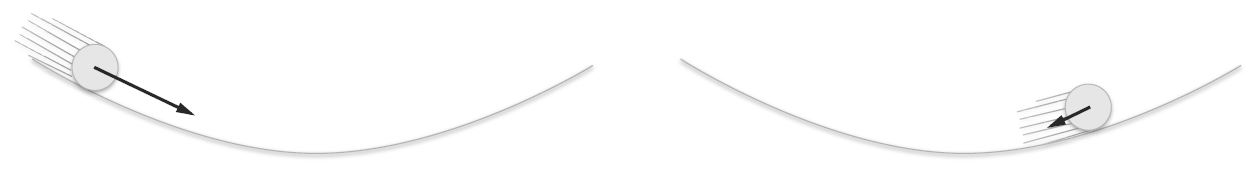

또, 식의 $\alpha v$항은 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할을 한다. ($\alpha$는 0.9등의 값으로 설정한다).  
물리에서의 지면 마찰이나 공기 저항에 해당한다. 다음은 모멘텀의 구현이다.

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

인스턴수 변수 v가 물체의 속도이다. v는 초기화 때는 아무 값도 담지 않고, 대신 update()가 처음 호출될 때 매개변수와 같은 구조의 데이터를 딕셔너리 변수로 저장한다.

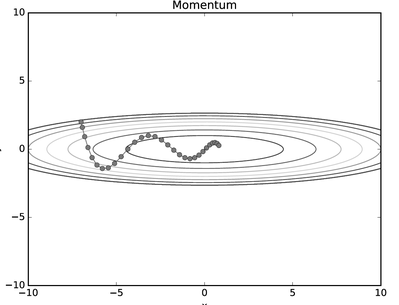<br>
그림에서 보듯 모멘텀의 갱신 경로는 공이 그릇 바닥을 구르듯 움직인다. SGD와 비교하면 '지그재그 정도'가 덜한 것을 알 수 있다. 이는 x축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문이다.<br><br>
거꾸로 y축의 힘은 크지만 위아래로 번갈아 받아서 상승하여 y축 방향의 속도는 안정적이지 않다.<br><br>
**전체적으로는 SGD보다 x축 방향으로 빠르게 다가가 지그재그 움직임이 줄어든다.**

## 6.1.5 AdaGrad
신경망 학습에서는 학습률($\eta$)값이 중요하다. 이 값이 너무 작으면 학습 시간이 너무 길어지고, 반대로 너무 크면 발산하여 학습이 제대로 이뤄지지 않는다.<br><br>
이 학습률을 정하는 효과적 기술로 **학습률 감소(learning rate decay)** 가 있다. 이는 학습을 진행하면서 학습을 점차 줄여가는 방법이다. 처음에는 크게 학습하다가 조금씩 작게 학습한다는 얘기로, 실제 신경망 학습에 자주 쓰인다.<br><br>
학습률을 서서히 낮추는 가장 간단한 방법은 매개변수 '전체'의 학습률 값을 일괄적으로 낮추는 것이다. 이를 더욱 발전시킨 것이 **AdaGrad**이다. AdaGrad는 '각각의' 매개변수에 '맞춤형' 값을 만들어 준다.

AdaGrad는 개별 매개변수에 적응적으로 학습률을 조정하면서 학습을 진행한다.<br><br>
AdaGrad의 갱신 방법은 수식으로는 다음과 같다.<br><br>
$$ h = h + \frac{\alpha L}{\alpha W} * \frac{\alpha L}{\alpha W} $$<br><br>
$$ W = W - \eta \frac{1}{\sqrt h}\frac{\alpha L}{\alpha W} $$

마찬가지로 W는 갱신할 가중치 매개변수, $\frac{\alpha L}{\alpha W}$은 $W$에 대한 손실 함수의 기울기, $\eta$는 학습률을 뜻한다.  
여기에서는 새로 $h$라는 변수가 등장한다. $h$는 위의 식에서 보듯 기존 기울기 값을 제곱하여 계속 더해준다. 그리고 매개변수를 갱신할 때 $\frac{1}{\sqrt h}$을 곱해 학습률을 조정한다.<br><br> 
매개변수의 원소 중에서 많이 움직인 원소는 학습률이 낮아진다는 뜻인데, 다시 말해 학습률 감소가 매개변수의 원소마다 다르게 적용됨을 뜻한다.

In [3]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + 1e-7))

여기에서 주의할 것은 마지막 줄에서 $1e-7$이라는 작은 값을 더하는 부분이다. 이 작은 값은 self.h[key]에 0이 담겨 있다 해도 0으로 나누는 사태를 막아준다. 대부분의 딥러닝 프레임워크에서는 이 값도 인수로 설정할 수 있다.

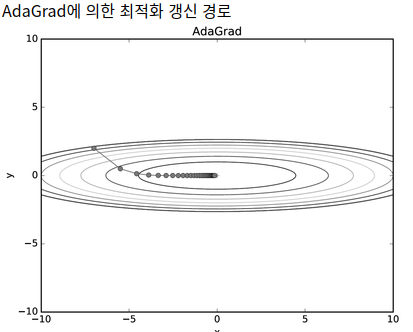

그림을 보면 최솟값을 향해 효율적으로 움직이는 것을 알 수 있다. y축 방향은 기울기가 커서 처음에는 크게 움직이지만, 그 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정된다. 그래서 y축 방향으로 갱신 강도가 빠르게 약해지고, 지그재그 움직임이 줄어든다.

## 6.1.6 Adam
모멘텀은 공이 그릇 바닥을 구르는 듯한 움직임을 보였다. AdaGrad는 매개변수의 원소마다 적응적으로 갱신 정도를 조정하였다. 그럼 이 두 기법을 융합하여 출발한 기법이 바로 **Adam** 이다.<br><br>
**Adam** 은 직관적으로는 모멘텀과 AdaGrad를 융합한 듯한 방법으로, 하이퍼파라미터의 '편향 보정'이 진행된다는 특징이 있다.

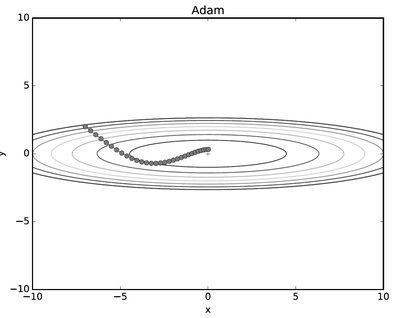

그림과 같이 Adam 갱신 과정도 그릇 바닥을 구르듯 움직인다. 모멘텀과 비슷한 패턴인데, 모멘텀 때보다 공의 좌우 흔들림이 적다. 이는 학습의 갱신 강도를 적응적으로 조정해서 얻는 혜택이다.

## 6.1.7 어느 갱신 방법을 이용할 것인가?
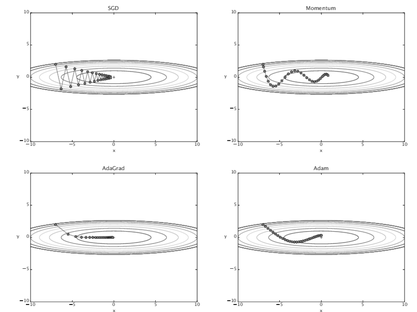<br><br>
SGD, 모멘텀, AdaGrad, Adam의 네 후보 중 유감스럽게도 모든 문제에서 항상 뛰어난 기법이라는 것은 (아직까진) 없다. 각자의 장단이 있어 잘 푸는 문제와 서툰 문제가 있다.<br><br>
지금도 많은 연구에서 SGD를 사용하고 있으며, 요즘에는 많은 사람들이 Adam에 만족해하며 쓰고 있다.

## 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교
손글씨 숫자 인식을 대상으로 지금까지 설명한 네 기법을 비교해본다.
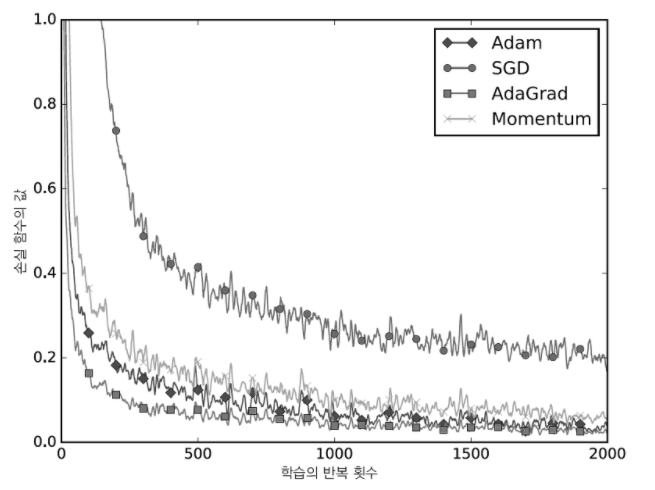<br><br>
결과를 보면 SGD의 학습 진도가 가장 느리다. 나머지 세 기법의 진도는 비슷한데, 잘 보면 AdaGrad가 조금 더 빠르다. 이 실험에서 주의할 점은 하이퍼파라미터인 학습률과 신경망의 구조에 따라 결과가 달라진다는 것이다.<br><br>
다만 일반적으로 SGD보다 다른 세 기법이 빠르게 학습하고, 때로는 최종 정확도도 높게 나타난다.

# 6.2 가중치의 초깃값
신경망 학습에서 특히 중요한 것이 가중치의 초깃값이다. 가중치의 초깃값을 무엇으로 설정하느냐가 신경망 학습의 성패가 가르는 일이 자주 있다. 

## 6.2.1 초깃값을 0으로 하면?
이제 오버피팅을 억제해 범용 성능을 높이는 테크닉인 **가중치 감소** 기법을 소개한다. 가중치 감소는 간단히 말하자면 가중치 매개변수의 값이 작아지도록 학습하는 방법이다. 가중치 값을 작게 하여 오버피팅이 일어나지 않게 하는 것이다.<br><br>

가중치를 작게 만들고 싶으면 초깃값도 최대한 작은 값에서 시작하는 것이 정공법이다. 그렇다면 가중치의 초깃값을 모두 0으로 설정하면 어떨까? 답부터 얘기하면, 이는 나쁜 아이디어이다. 실제로 가중치 초깃값을 0으로 하면 학습이 올바로 이뤄지지 않는다.<br><br>

초깃값을 0으로 하면 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문이다. 그래서 가중치가 고르게 되어버리는 상황을 막으려면 초깃값을 무작위로 설정해야 한다.

## 6.2.2 은닉층의 활성화값 분포
은닉층의 활성화값(활성화 함수의 출력 데이터)의 분포를 관찰하면 중요한 정보를 얻을 수 있다. 이번 절에서는 가중치의 초깃값에 따라 은닉층 활성화값들이 어떻게 변화하는지 간단한 실험을 해본다.<br><br>
구체적으로는 활성화 함수로 시그모이드 함수를 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 흘리며 각 층의 활성화값 분포를 히스토그램으로 그려본다.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) # 1000개의 데이터
node_num = 100                 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5          # 5개의 은닉층
activations = {}               # 이곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

층이 5개가 있으며, 각 층의 뉴런은 100개씩이다. 입력 데이터로서 1,000개의 데이터를 정규분포로 무작위로 생성하여 이 5층 신경망에 흘린다. 활성화 함수로는 시그모이드 함수를 이용했고, 각 층의 활성화 결과를 activations 변수에 저장한다.<br><br>
이 코드에서는 가중치의 분포에 주의해야 한다. 이번에는 표준편차가 1인 정규분포를 이용했는데, 이 분포된 정도(표준편차)를 바꿔가며 활성화값들의 분포가 어떻게 변화하는지 관찰하는 것이 이 실험의 목적이다.

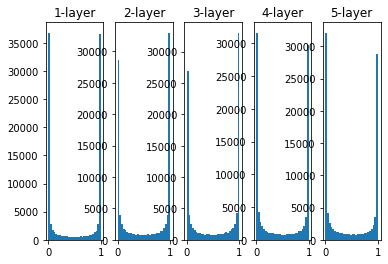

In [10]:
# 히스토그램 늘리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
    
plt.show()

각 층의 활성화값들이 0과 1에 치우쳐 분포되어 있다. 여기서 사용한 시그모이드 함수는 그 출력이 0에 가까워지자(또는 1에 가까워지자) 그 미분은 0에 다가간다. 그래서 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라진다. 이것이 **기울기 소실** 이다. 층을 깊게 하는 딥러닝에서는 기울기 소실은 더 심각한 문제가 될 수 있다.

이번에는 가중치의 표준 편차를 0.01로 바꿔 같은 실험을 반복한다.

In [11]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]
        
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

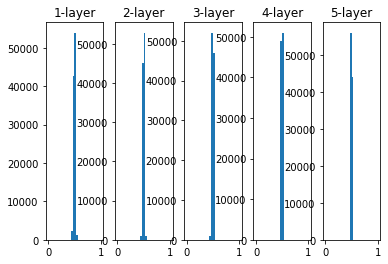

In [12]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
    
plt.show()

이번에는 0.5 부근에 집중되었다. 앞의 예처럼 0과 1로 치우치지 않아서 기울기 소실 문제는 일어나지 않으나, 활성화값들이 치우쳤다는 것은 표현력 관점에서는 큰 문제가 있는 것이다.<br><br>
이 상황에서는 다수의 뉴런이 거의 같은 값을 출력하고 있으니 뉴런을 여러 개 둔 의미가 없어진다는 뜻이다. 그래서 활성화값들이 치우치면 **표현력을 제한**한다는 관점에서 문제가 된다.

**Xavier 초깃값**은 일반적인 딥러닝 프레임워크들이 표준적으로 이용하고 있다. 예를 들어 카페 프레임워크는 가중치 초깃값을 설정할 때 인수로 xavier를 지정할 수 있다.<br><br>
이 논문은 각 층의 활성화값들을 광법위하게 분포시킬 목적으로 가중치의 적절한 분포를 찾고자 하였다. 그리고 앞 계층의 노드가 $n$개라면 표준편차가 $\frac{1}{\sqrt n}$인 분포를 사용하면 된다는 결론을 이끌었다.
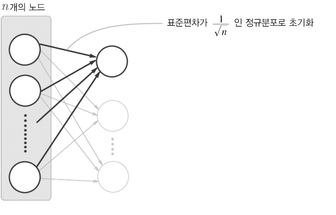<br><br>
Xabier 초깃값을 사용하면 앞 층에 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 펴진다. 이제 Xavier 초깃값을 써서 실험해본다.

In [13]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

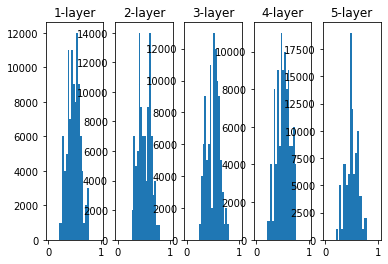

In [14]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
    
plt.show()

Xavier 초깃값을 사용한 결과를 보면 층이 깊어지면서 형태가 다소 일그러지지만, 앞에서 본 방식보다는 확실히 넓게 분포됨을 알 수 있다. 각 층에 흐르는 데이터는 적당히 퍼져 있으므로, 시그모이드 함수의 표현력도 제한받지 않고 학습이 효율적으로 이뤄질 것으로 기대된다.